In [6]:
import sys
sys.path.insert(0, "../")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from tqdm import tqdm
from omegaconf import OmegaConf
from cai.plmodule.module import HPASSCModule
from cai.pldatamodule.datamodule import HPASSCDataModule

pl.seed_everything(42, workers=True)

Global seed set to 42


42

In [84]:
ckpt = "../models/epoch=49-step=3400.ckpt"
cfg = OmegaConf.to_container(OmegaConf.load("/mnt/yando/Users/yando/Experiments/cai/outputs/2022-12-12/23-25-29/.hydra/config.yaml"))

#ckpt = "../models/epoch=31-step=2048.ckpt"
#cfg = OmegaConf.to_container(OmegaConf.load("/mnt/yando/Users/yando/Experiments/cai/multirun/2022-12-13/16-52-16/0/.hydra/config.yaml"))

#ckpt = "../models/epoch=26-step=1836.ckpt"
#cfg = OmegaConf.to_container(OmegaConf.load("/mnt/yando/Users/yando/Experiments/cai/multirun/2022-12-13/00-17-30/0/.hydra/config.yaml"))

In [85]:
inference_transforms = [
        [
            {
                "module" : "tv_transforms",
                 "name" : "CenterCrop",
                 "kwargs" : {
                     "size" : [1568, 1568]
                 }
            },
            {
                "module" : "tv_transforms",
                "name" : "Normalize",
                "kwargs" : {
                    "mean" : [0.06438801, 0.0441467, 0.03966651, 0.06374957],
                    "std" : [0.10712028, 0.08619478, 0.11134183, 0.10635688]
                }
            },
            {
                "module" : "tv_transforms",
                "name" : "Resize",
                "kwargs" : {
                    "size" : [224, 224]
                }
            }
        ],
        [
            {
                "module" : "tv_transforms",
                 "name" : "CenterCrop",
                 "kwargs" : {
                     "size" : [1568, 1568]
                 }
            },
            {
                "module" : "tv_transforms",
                "name" : "Normalize",
                "kwargs" : {
                    "mean" : [0.06438801, 0.0441467, 0.03966651, 0.06374957],
                    "std" : [0.10712028, 0.08619478, 0.11134183, 0.10635688]
                }
            },
            {
                "module" : "nn",
                "name" : "Unfold",
                "kwargs" : {
                    "kernel_size" : [224,224],
                    "stride" : 224
                }
            }
        ]
]

In [86]:
cfg["module"]["loss_fn"]["module"] = "nn"
cfg["datamodule"]["dataset"]["transforms"] = inference_transforms[1]
cfg["datamodule"]["dataloader"]["batch_size"]=3
cfg["datamodule"]["dataloader"]["num_workers"]=15
cfg["datamodule"]["dataloader"]["prefetch_factor"]=5
cfg["datamodule"]["use_wr_sampler"] = False
del cfg["datamodule"]["dataloader"]["sampler"]

In [87]:
device = "cuda:0"
module = HPASSCModule.load_from_checkpoint(ckpt, **cfg["module"]).to(device)
datamodule = HPASSCDataModule(**cfg["datamodule"])
module.eval()
datamodule.setup()

In [140]:
idx = (torch.rand(1) * len(datamodule.val_dataset)).to(torch.int)
image, label = datamodule.val_dataset[idx]
image = image.permute(1,0).view(49, -1, 224, 224)
image = image.to(device)
output = module.reduce_channel(image)
output = module.model(output, output_attentions=True)
output.logits.shape, len(output.attentions), output.attentions[0].shape
pred_label = torch.softmax(output.logits, dim=1).max(dim=0).values.sort(descending=True).indices[:3]
print(torch.argmax(label), pred_label)

tensor(13) tensor([16,  0, 13], device='cuda:0')


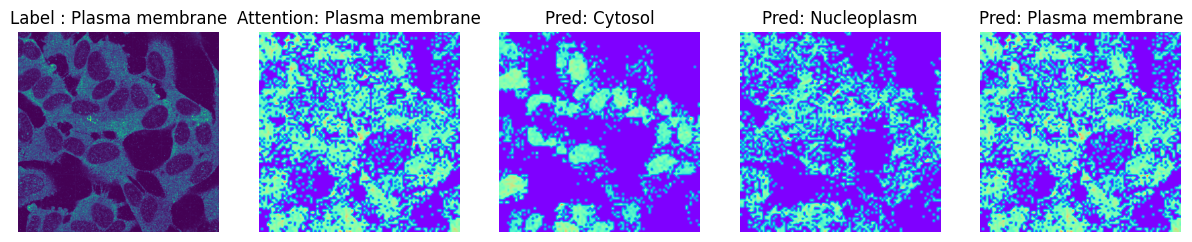

In [141]:

n_tiles, nh, _, _ = output.attentions[-1].shape

cla = pred_label[0]
id2label = cfg['module']['vit_config']['id2label']

def get_attentions(output, cla, threshold = 0.0003, layer = -1):
    grad = torch.zeros_like(output.attentions[layer])
    for tile in range(n_tiles):
        grad += torch.autograd.grad(output.logits[tile, cla], output.attentions[layer], retain_graph=True)[0] 
    attentions = output.attentions[-1][:, :, 0, 1:] * grad[:,:,0,1:]
    attentions = (attentions * (attentions > threshold)).view(n_tiles, nh, -1)
    return attentions

fig, ax = plt.subplots(1, 5, figsize=(15,4))
image_grid = vutils.make_grid(image[:,1,:,:].unsqueeze(1), nrow=7, ncol=7).permute(1,2,0).mean(dim=-1).cpu()

ax[0].imshow(image_grid)
ax[0].set_axis_off()
ax[0].set_title(f"Label : {id2label[torch.argmax(label).item()]}")

attentions = get_attentions(output, torch.argmax(label).item())
grid = vutils.make_grid(attentions[:,:,:].max(dim=1).values.view(-1, 1, 14, 14), nrow=7, ncol=7, padding=0, normalize=True)
grid = transforms.functional.resize(grid, (1568, 1568)).cpu().permute(1,2,0)
ax[1].imshow(grid[:,:,0], cmap=plt.cm.rainbow)
ax[1].set_axis_off()
ax[1].set_title(f"Attention: {id2label[torch.argmax(label).item()]}")

pred_labels = pred_label.cpu().numpy()
for i in range(3):
    attentions = get_attentions(output, pred_labels[i])
    grid = vutils.make_grid(attentions[:,:,:].max(dim=1).values.view(-1, 1, 14, 14), nrow=7, ncol=7, padding=0, normalize=True)
    grid = transforms.functional.resize(grid, (1568, 1568)).cpu().permute(1,2,0)
    ax[i+2].imshow(grid[:,:,0], cmap=plt.cm.rainbow)
    ax[i+2].set_axis_off()
    ax[i+2].set_title(f"Pred: {id2label[pred_labels[i]]}")
plt.show()